In [1]:
import numpy as np
from basis import Bspline
from plssmooth import PLSS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example of Penalised Least Square Smoothing
<hr>

The following notebook shows an example of using the ``plssmooth`` module and the ``PLSS`` class for representing such a procedure. We first simulate a series of univariata data which is observed with error which we then smooth using a penalised least square smooth. 

## Simulation
<hr>

We simulate observed data from ``25 subjects`` with the following data model from $t_j \in [0,10],~j=1,...,128$: 

$$ y_i(t_j) = \mu(t_j) + \zeta_i \phi(t_j) +  \varepsilon_j $$

where $i$ indexes are subject, $j$ indexes our observed time point, $\zeta_i \sim \mathcal{N}(0,1)$, $\mu, \phi$ are a known functions, and $\varepsilon_j \sim \mathcal{N}(0,0.5)$ is a white noise process. 

In [2]:
def mu(t):
    return t + np.sin(t)

def phi(t):
    return 5* np.cos(2*t*np.pi/10)/np.sqrt(5)

def simulate(n,t):
    X = mu(t)[:, np.newaxis] + np.random.normal(0,1,n)*phi(t)[:, np.newaxis] 
    Y = X + np.random.normal(0,0.5, X.shape)
    return X, Y


In [3]:
n = 25
T = [0,10]
t = np.linspace(*T, 128)
X, Y = simulate(n, t)

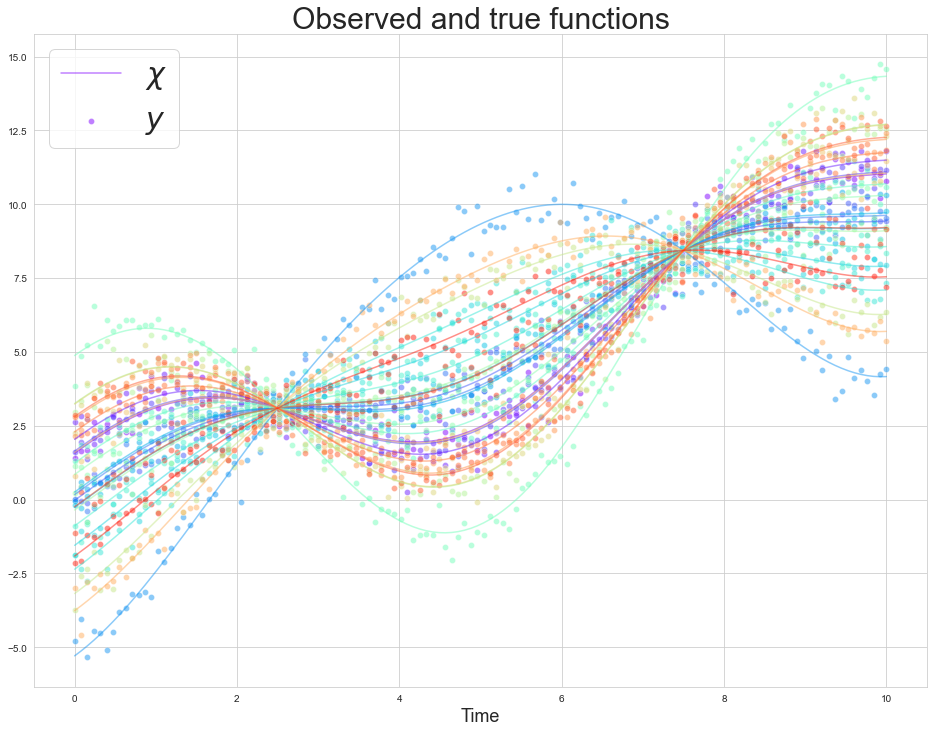

In [4]:
sns.set_style('whitegrid')
z_map = sns.color_palette("rainbow", as_cmap=True)
fig, axs = plt.subplots(1, 1, figsize=(16,12))
for i, (y, x) in enumerate(zip(Y.T, X.T)):
    inds = np.where(y != 0)
    t_inds = t[inds]
    if i == 0:
        axs = sns.lineplot(x=t, y=x, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)),  label=r'$\chi$', legend=False)
        axs = sns.scatterplot(x=t_inds, y=y[inds], alpha=0.5, color=z_map(i/len(Y.T)), ax=axs, legend=False, label=r'$y$')
    else:
        axs = sns.lineplot(x=t, y=x, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), legend=False)
        axs = sns.scatterplot(x=t_inds, y=y[inds], alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), legend=False)
axs.legend(fontsize=30)
axs.set_xlabel('Time', fontsize=18)
axs.set_title('Observed and true functions', fontsize=30)
plt.show()

## Estimation
<hr>

The ``PLSS`` class offers three methods to fit data using the penalised least squares fitting criterion. These all deal with how to choose the regularisation hyper parameter, $\lambda$ in the minimisation criterion:

$$ \sum_{i=1}^n \sum_{j=1}^{N} w_{ij} ( y_i(t_j) - B^\top(t_j)\mathbf{c})^2 + \lambda \mathbf{c}^\top P \mathbf{c} $$

where $N$ is the number of temporal observations, $P$ is a penalty matrix, and $w_{ij}$ is the weight associated to each observation. In the following we show the ``rgcv`` method which chooses $\lambda$ using the robust generalised cross validation algorithm. The other options are ``fixed`` in that case $\lambda$ is fixed in the methodology, and ``gcv`` which is just the generalised cross validation procedure.  

In [5]:
bs = Bspline(T, 25, 3)
B = bs(t)
P = bs.penalty(2)

model = PLSS(method='rgcv', options={'bounds':[-8,8], 'N':50})
C_hat, log_lambda = model.fit(Y.T, B, P)
X_hat = np.matmul(B, C_hat).T
print(log_lambda)

[-0.17522723]


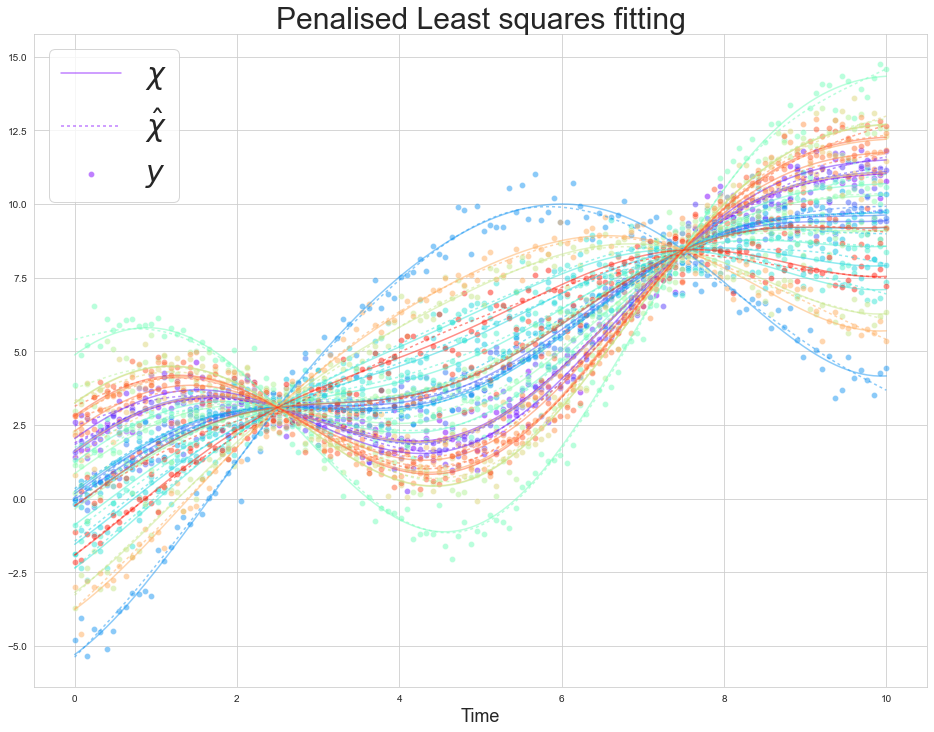

In [6]:
z_map = sns.color_palette("rainbow", as_cmap=True)
fig, axs = plt.subplots(1, 1, figsize=(16,12))
for i, (y, x, x_hat) in enumerate(zip(Y.T, X.T, X_hat)):
    inds = np.where(y != 0)
    t_inds = t[inds]
    if i == 0:
        axs = sns.lineplot(x=t, y=x, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)),  label=r'$\chi$', legend=False)
        axs = sns.lineplot(x=t, y=x_hat, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), style=True,  dashes=[(2,2)] , label=r'$\hat{\chi}$', legend=False)
        axs = sns.scatterplot(x=t_inds, y=y[inds], alpha=0.5, color=z_map(i/len(Y.T)), ax=axs, legend=False, label=r'$y$')
    else:
        axs = sns.lineplot(x=t, y=x, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), legend=False)
        axs = sns.scatterplot(x=t_inds, y=y[inds], alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), legend=False)
        axs = sns.lineplot(x=t, y=x_hat, alpha=0.5, ax=axs, color=z_map(i/len(Y.T)), style=True, dashes=[(2,2)] , legend=False)

axs.legend(fontsize=30)
axs.set_xlabel('Time', fontsize=18)
axs.set_title("Penalised Least squares fitting", fontsize=30)
plt.show()